In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install seqeval
!pip install transformers

In [3]:
!pip install tensorflow==2.2.1
!pip install keras==2.3.1

In [4]:
# Check library version
!pip list | grep -E 'transformers|torch|Keras'

Keras                         2.3.1
Keras-Applications            1.0.8
Keras-Preprocessing           1.1.2
torch                         1.10.0+cu111
torchaudio                    0.10.0+cu111
torchsummary                  1.5.1
torchtext                     0.11.0
torchvision                   0.11.1+cu111
transformers                  4.16.2


In [1]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F

In [2]:
import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW

2022-10-07 21:56:24.275645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 21:56:24.830594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 21:56:24.830629: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-07 21:56:24.902442: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 21:56:26.149122: W tensorflow/stream_executor/platform/de

Moving 0 files to the new cache system


0it [00:00, ?it/s]

This notebook work with env:

- Keras                2.3.1                 
- torch                1.1.0                 
- transformers         2.5.1      

# Introduction

In this notebook, will introduce how to do NER with BERT, including:

- Load and preprocess data
- Parser data
- Make training data
- Train model
- Evaluate result
- **Inference**

## Load data

In [7]:
# connect ggdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#path="/content/drive/MyDrive/LUẬN VĂN-K18_CQ/02. Bình-Ngọc/Data/Dataset/conll/simple/"
path='/home/tyeson/Desktop/ML_NER/Train_Dataset/'

In [4]:
# add dataset
sentences = []
count=0
'''
f1 = open(path+'csr.conll', 'r', encoding="utf-8")
for i in f1:
    l = i.split(' ')
    #print(l)
    if (i == '\n'):
        count+=1
        continue
    if l[0] == '-DOCSTART-':
        continue
    sentences.append((count,l[0], l[3].strip('\n')))
f1.close()
print(len(sentences))
'''
f1 = open(path+'udemy_data.conll', 'r', encoding="utf-8")
for i in f1:
    l = i.split(' ')
    if (i == '\n'):
        count+=1
        continue
    if l[0] == '-DOCSTART-':
        continue
    sentences.append((count,l[0], l[3].strip('\n')))
f1.close()
print(len(sentences));

f1 = open(path+'udemy1.conll', 'r', encoding="utf-8")
for i in f1:
    l = i.split(' ')
    #print(l)
    if (i == '\n'):
        count+=1
        continue
    if l[0] == '-DOCSTART-':
        continue
    sentences.append((count,l[0], l[3].strip('\n')))
print(len(sentences))

f1 = open(path+'udemy2.conll', 'r', encoding="utf-8")
for i in f1:
    l = i.split(' ')
    #print(l)
    if (i == '\n'):
        count+=1
        continue
    if l[0] == '-DOCSTART-':
        continue
    sentences.append((count,l[0], l[3].strip('\n')))
print(len(sentences))

'''
f1 = open(path+'pro7.conll', 'r', encoding="utf-8")
for i in f1:
    l = i.split(' ')
    #print(l)
    if (i == '\n'):
        count+=1
        continue
    if l[0] == '-DOCSTART-':
        continue
    sentences.append((count,l[0], l[3].strip('\n')))
print(len(sentences))
'''

35270
136130
188624


'\nf1 = open(path+\'pro7.conll\', \'r\', encoding="utf-8")\nfor i in f1:\n    l = i.split(\' \')\n    #print(l)\n    if (i == \'\n\'):\n        count+=1\n        continue\n    if l[0] == \'-DOCSTART-\':\n        continue\n    sentences.append((count,l[0], l[3].strip(\'\n\')))\nprint(len(sentences))\n'

In [5]:
df_data = pd.DataFrame(sentences, columns=['Sentence #', 'Word', 'Tag'])

In [6]:
df_data.head(n=20)

,Sentence #,Word,Tag
0,0,OLAP,B-KNOW
1,0,vs,O
2,0,OLTP,B-KNOW
3,0,databases,B-KNOW
4,0,.,O
5,1,Cloud,B-KNOW
6,1,Storage,I-KNOW
7,1,.,O
8,2,Big,B-PLAT
9,2,Query,I-PLAT


**Have a look TAG cat**

In [7]:
df_data.Tag.unique()

array(['B-KNOW', 'O', 'I-KNOW', 'B-PLAT', 'I-PLAT', 'B-FRAM', 'I-FRAM',
       'B-LANG', 'B-TOOL', 'I-TOOL', 'I-LANG'], dtype=object)

In [8]:
# Analyse summary of data
df_data['Sentence #'].nunique(), df_data.Word.nunique(), df_data.Tag.nunique()

(11423, 14842, 11)

In [9]:
word_counts = df_data.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [10]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 847 words.


In [11]:
# Analyse the Tag distribution
df_data.Tag.value_counts()

O         171316
B-KNOW      5656
I-KNOW      5026
B-LANG      1713
B-TOOL      1644
B-FRAM       993
B-PLAT       893
I-TOOL       681
I-PLAT       354
I-FRAM       303
I-LANG        45
Name: Tag, dtype: int64

## Parser data

**Parser data into document structure**

In [12]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           #s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [13]:
# Get full document data struce
getter = SentenceGetter(df_data)

In [14]:
# Get sentence data
sentences = [[s[0] for s in sent] for sent in getter.sentences]
sentences[0]

['OLAP', 'vs', 'OLTP', 'databases', '.']

In [15]:
# Get pos data
poses = [[s[1] for s in sent] for sent in getter.sentences]
print(poses[0])

['B-KNOW', 'O', 'B-KNOW', 'B-KNOW', 'O']


In [16]:
# Get tag labels data
labels = [[s[1] for s in sent] for sent in getter.sentences]
print(labels[0])

['B-KNOW', 'O', 'B-KNOW', 'B-KNOW', 'O']


**Make TAG name into index for training**

In [17]:
tags_vals = list(set(df_data["Tag"].values))

In [18]:
# Add X  label for word piece support
# Add [CLS] and [SEP] as BERT need
#tags_vals.append('X')
tags_vals.append('[CLS]')
tags_vals.append('[SEP]')

In [19]:
tags_vals = set(tags_vals)

In [20]:
tags_vals

{'B-FRAM',
 'B-KNOW',
 'B-LANG',
 'B-PLAT',
 'B-TOOL',
 'I-FRAM',
 'I-KNOW',
 'I-LANG',
 'I-PLAT',
 'I-TOOL',
 'O',
 '[CLS]',
 '[SEP]'}

In [21]:
# Set a dict for mapping id to tag name
#tag2idx = {t: i for i, t in enumerate(tags_vals)}
tag2idx= {#'B-CERTIFICATION': 14,
 'B-FRAM': 1,
 'B-KNOW': 2,
 'B-LANG': 3,
 'B-PLAT': 4,
 'B-TOOL': 5,
 #'I-CERTIFICATION': 4,
 'I-FRAM': 6,
 'I-KNOW': 7,
 'I-LANG': 8,
 'I-PLAT': 9,
 'I-TOOL': 10,
 'O': 11,
 #'X': 6,
 '[CLS]': 12,
 '[SEP]': 0}

In [22]:
tag2idx

{'B-FRAM': 1,
 'B-KNOW': 2,
 'B-LANG': 3,
 'B-PLAT': 4,
 'B-TOOL': 5,
 'I-FRAM': 6,
 'I-KNOW': 7,
 'I-LANG': 8,
 'I-PLAT': 9,
 'I-TOOL': 10,
 'O': 11,
 '[CLS]': 12,
 '[SEP]': 0}

In [23]:
# Mapping index to name
tag2name={tag2idx[key] : key for key in tag2idx.keys()}

## Make training data

- Set gpu environment
- Load tokenizer and tokenize
- Set 3 embedding, token embedding, mask word embedding, segmentation embedding
- Split data set into train and validate, then send them to dataloader

**Set up gpu environment**

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [25]:
n_gpu

0

### Load tokenizer

In [26]:
# Len of the sentence must be not bigger than the training model
# See model's 'max_position_embeddings' = 512
max_len  = 256

In [27]:
model_cp="bert-base-uncased"

In [28]:
# load tokenizer
tokenizer=BertTokenizer.from_pretrained(model_cp)

**Tokenizer text**

In [29]:
tokenized_texts = []
word_piece_labels = []
i_inc = 0
for word_list,label in (zip(sentences,labels)):
    temp_lable = []
    temp_token = []
    
    # Add [CLS] at the front 
    temp_lable.append('[CLS]')
    temp_token.append('[CLS]')
    
    for word,lab in zip(word_list,label):
        token_list = tokenizer.tokenize(word)
        for m,token in enumerate(token_list):
            temp_token.append(token)
            if m==0:
                temp_lable.append(lab)
            else:
                if lab != 'O':
                  temp_lable.append('I-'+lab[2:])
                else:
                  temp_lable.append('O') 
                
    # Add [SEP] at the end
    temp_lable.append('[SEP]')
    temp_token.append('[SEP]')
    
    tokenized_texts.append(temp_token)
    word_piece_labels.append(temp_lable)
    
    if 5 > i_inc:
        print("No.%d,len:%d"%(i_inc,len(temp_token)))
        print("texts:%s"%(" ".join(temp_token)))
        print("No.%d,len:%d"%(i_inc,len(temp_lable)))
        print("lables:%s"%(" ".join(temp_lable)))
    i_inc +=1
    
    
    

No.0,len:9
texts:[CLS] ol ##ap vs ol ##tp databases . [SEP]
No.0,len:9
lables:[CLS] B-KNOW I-KNOW O B-KNOW I-KNOW B-KNOW O [SEP]
No.1,len:5
texts:[CLS] cloud storage . [SEP]
No.1,len:5
lables:[CLS] B-KNOW I-KNOW O [SEP]
No.2,len:5
texts:[CLS] big query . [SEP]
No.2,len:5
lables:[CLS] B-PLAT I-PLAT O [SEP]
No.3,len:18
texts:[CLS] update of big query practical ##s including authorised views in the new b ##q ui . [SEP]
No.3,len:18
lables:[CLS] O O B-PLAT I-PLAT O O O O O O O O O O O O [SEP]
No.4,len:5
texts:[CLS] big ##table . [SEP]
No.4,len:5
lables:[CLS] B-KNOW I-KNOW O [SEP]


### Set token embedding

In [30]:
# Make text token into id
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")
print(input_ids[0])

[  101 19330  9331  5443 19330 25856 17881  1012   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [31]:
# Make label into id, pad with "O" meaning others
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in word_piece_labels],
                     maxlen=max_len, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")
print(tags[0])

[12  2  7 11  2  7  2 11  0 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]


### Set mask word embedding

In [32]:
# For fine tune of predict, with token mask is 1,pad token is 0
attention_masks = [[int(i>0) for i in ii] for ii in input_ids]
attention_masks[0];

### Set segment embedding(Seem like for sequance tagging task, it's not necessary to make this embedding)

In [33]:
# Since only one sentence, all the segment set to 0
segment_ids = [[0] * len(input_id) for input_id in input_ids]
segment_ids[0];

## Split data into train and validate

70% for training, 30% for validation

**Split all data**

In [34]:
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(input_ids, tags,attention_masks,segment_ids, 
                                                            random_state=4, test_size=0.2)

In [35]:
len(tr_inputs),len(val_inputs),len(tr_segs),len(val_segs)

(9138, 2285, 9138, 2285)

**Set data into tensor**

Not recommend tensor.to(device) at this process, since it will run out of GPU memory

In [36]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
tr_segs = torch.tensor(tr_segs)
val_segs = torch.tensor(val_segs)

**Put data into data loader**

In [37]:
# Set batch num
batch_num = 32

In [38]:
# Only set token embedding, attention embedding, no segment embedding
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

## Train model

**Load BERT model**

In [39]:
# In this folder, contain model confg(json) and model weight(bin) files
model_file_address = 'bert-base-uncased'

In [40]:
# Will load config and weight with from_pretrained()
model = BertForTokenClassification.from_pretrained(model_file_address,num_labels=len(tag2idx))

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [41]:
model;

In [42]:
# Set model to GPU,if you are using GPU machine
model.cuda();

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [43]:
# Add multi GPU support
if n_gpu >1:
    model = torch.nn.DataParallel(model)

In [44]:
# Set epoch and grad max num
epochs = 5
max_grad_norm = 1.0

In [45]:
# Cacluate train optimiazaion num
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

### Set fine tuning method

**Manual optimizer**

In [46]:
# True: fine tuning all the layers 
# False: only fine tuning the classifier layers
FULL_FINETUNING = True

In [47]:
if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5)

/home/tyeson/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Fine-tuning model

In [ ]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))
loss_values = []
model.train();
#validation_loss_values = []

for _ in trange(epochs,desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # forward pass
        outputs = model(b_input_ids, token_type_ids=None,
        attention_mask=b_input_mask, labels=b_labels)
        loss, scores = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    avg_train_loss= tr_loss/nb_tr_steps 
    print("Train loss: {}".format(avg_train_loss))
     
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

***** Running training *****
  Num examples = 9138
  Batch size = 32
  Num steps = 1430



Epoch:   0%|                                              | 0/5 [00:00<?, ?it/s]

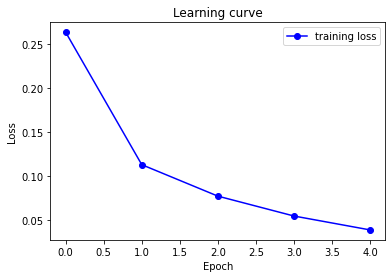

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
#plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend() 

plt.show()

## Save model 

In [55]:
#bert_out_address = '/content/models/bert_out_model/en09'
#bert_out_address ="/content/drive/MyDrive/LUẬN VĂN-K18_CQ/02. Bình-Ngọc/Data/Dataset/conll/b_simp"
bert_out_address = '/home/tyeson/Desktop/ML_NER/Test_Train_Dataset/'

In [56]:
# Make dir if not exits
if not os.path.exists(bert_out_address):
        os.makedirs(bert_out_address)

In [57]:
# Save a trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

In [58]:
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(bert_out_address, "pytorch_model.bin")
output_config_file = os.path.join(bert_out_address, "config.json")

In [59]:
# Save model into file
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(bert_out_address)

('/content/drive/MyDrive/LUẬN VĂN-K18_CQ/02. Bình-Ngọc/Data/Dataset/conll/b_simp/vocab.txt',)

## Load model

In [60]:
model = BertForTokenClassification.from_pretrained(bert_out_address,num_labels=len(tag2idx))

In [61]:
# Set model to GPU
model.cuda();

In [62]:
if n_gpu >1:
    model = torch.nn.DataParallel(model)

## Eval model

In [63]:
# Evalue loop
model.eval();

In [64]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
y_true = []
y_pred = []

print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, label_ids = batch
    
#     if step > 2:
#         break
    
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None,
        attention_mask=input_mask,)
        # For eval mode, the first result of outputs is logits
        logits = outputs[0] 
    
    # Get NER predict result
    logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
    logits = logits.detach().cpu().numpy()
    
    
    # Get NER true result
    label_ids = label_ids.to('cpu').numpy()
    
    
    # Only predict the real word, mark=0, will not calculate
    input_mask = input_mask.to('cpu').numpy()
    
    # Compare the valuable predict result
    for i,mask in enumerate(input_mask):
        # Real one
        temp_1 = []
        # Predict one
        temp_2 = []
        
        for j, m in enumerate(mask):
            # Mark=0, meaning its a pad word, dont compare
            if m:
                if tag2name[label_ids[i][j]] != "" and tag2name[label_ids[i][j]] != "X" and tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                    temp_1.append(tag2name[label_ids[i][j]])
                    temp_2.append(tag2name[logits[i][j]])
            else:
                break
        
        y_true.append(temp_1)
        y_pred.append(temp_2)
print(len(y_true))
print(len(y_pred))
        
print("f1 socre: %f"%(f1_score(y_true, y_pred)))
print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))

# Get acc , recall, F1 result report
report = classification_report(y_true, y_pred,digits=4)
print(report)


***** Running evaluation *****
  Num examples =2443
  Batch size = 32
2443
2443
f1 socre: 0.730023
Accuracy score: 0.954697
              precision    recall  f1-score   support

        FRAM     0.7639    0.8599    0.8091       207
        KNOW     0.7145    0.6273    0.6681      1532
        LANG     0.9511    0.9138    0.9321       383
        PLAT     0.6590    0.6777    0.6682       211
        TOOL     0.7375    0.7788    0.7576       321

   micro avg     0.7522    0.7091    0.7300      2654
   macro avg     0.7652    0.7715    0.7670      2654
weighted avg     0.7509    0.7091    0.7280      2654



In [65]:
print("f1 socre: %f"%(f1_score(y_true, y_pred)))

f1 socre: 0.730023


In [66]:
# Debug =))
ele= [j for i in y_true for j in i]
myset = set(ele)
print(myset)


{'I-TOOL', 'B-PLAT', 'O', 'B-LANG', 'B-TOOL', 'I-KNOW', 'I-FRAM', 'I-LANG', 'B-KNOW', 'B-FRAM', 'I-PLAT'}


In [67]:
# Save the report into file
output_eval_file = os.path.join(bert_out_address, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    print("\n%s"%(report))
    print("f1 socre: %f"%(f1_score(y_true, y_pred)))
    print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))
    
    writer.write("f1 socre:\n")
    writer.write(str(f1_score(y_true, y_pred)))
    writer.write("\n\nAccuracy score:\n")
    writer.write(str(accuracy_score(y_true, y_pred)))
    writer.write("\n\n")  
    writer.write(report)

***** Eval results *****

              precision    recall  f1-score   support

        FRAM     0.7639    0.8599    0.8091       207
        KNOW     0.7145    0.6273    0.6681      1532
        LANG     0.9511    0.9138    0.9321       383
        PLAT     0.6590    0.6777    0.6682       211
        TOOL     0.7375    0.7788    0.7576       321

   micro avg     0.7522    0.7091    0.7300      2654
   macro avg     0.7652    0.7715    0.7670      2654
weighted avg     0.7509    0.7091    0.7280      2654

f1 socre: 0.730023
Accuracy score: 0.954697


## Inference

After we trained a model, we can make it into service ---- sending a new sentence to the model,then get the prediction.

The process contains:

- Load model
- Load tokenizer
- Set test query
- Make query into embedding
- Predict with model
- Parser result

### Set tag index

In [68]:
# Tag to index, must be the same as we training
#tag2idx={}

In [69]:
# Mapping index to name
#tag2name={tag2idx[key] : key for key in tag2idx.keys()}

### Load model

In [70]:
# Model we trained before, the dir containing pytorch_model.bin and vocab.txt
#save_model_address = 'models/bert_out_model/en09'
#save_model_address ="/content/drive/MyDrive/LUẬN VĂN-K18_CQ/02. Bình-Ngọc/Data/Dataset/conll/b_simp"
save_model_address = '/home/tyeson/Desktop/ML_NER/Test_Train_Dataset/'

In [71]:
tag2idx

{'B-FRAM': 1,
 'B-KNOW': 2,
 'B-LANG': 3,
 'B-PLAT': 4,
 'B-TOOL': 5,
 'I-FRAM': 6,
 'I-KNOW': 7,
 'I-LANG': 8,
 'I-PLAT': 9,
 'I-TOOL': 10,
 'O': 11,
 '[CLS]': 12,
 '[SEP]': 0}

In [72]:
save_model = BertForTokenClassification.from_pretrained(save_model_address,num_labels=len(tag2idx))

### Load Tokenizer

In [73]:
# Here, our save model address containing pytorch_model.bin and vocab.txt
# So, we can load the tokenzier from the same dir as the save model address
tokenizer = BertTokenizer.from_pretrained(save_model_address,do_lower_case=True)

In [74]:
# Set max sentence length, must be the same as our training process
max_len  = 256

### Set test query

In [75]:
test_query = 'You can start creating your own data science projects and collaborating with other data scientists using IBM Watson Studio. When you sign up, you will receive free access to Watson Studio. Start now and take advantage of this platform and learn the basics of programming, machine learning, and data visualization with this introductory course.'

### Make query into embeddings

- token id embedding, need to tokenize first
- mask word embedding
- segmentation embedding

In [76]:
tokenized_texts = []

In [77]:
temp_token = []

In [78]:
# Add [CLS] at the front 
temp_token.append('[CLS]')

In [79]:
token_list = tokenizer.tokenize(test_query)

In [80]:
token_list

['you',
 'can',
 'start',
 'creating',
 'your',
 'own',
 'data',
 'science',
 'projects',
 'and',
 'collaborating',
 'with',
 'other',
 'data',
 'scientists',
 'using',
 'ibm',
 'watson',
 'studio',
 '.',
 'when',
 'you',
 'sign',
 'up',
 ',',
 'you',
 'will',
 'receive',
 'free',
 'access',
 'to',
 'watson',
 'studio',
 '.',
 'start',
 'now',
 'and',
 'take',
 'advantage',
 'of',
 'this',
 'platform',
 'and',
 'learn',
 'the',
 'basics',
 'of',
 'programming',
 ',',
 'machine',
 'learning',
 ',',
 'and',
 'data',
 'visual',
 '##ization',
 'with',
 'this',
 'introductory',
 'course',
 '.']

In [81]:
for m,token in enumerate(token_list):
    temp_token.append(token)

In [82]:
# Trim the token to fit the length requirement
if len(temp_token) > max_len-1:
    temp_token= temp_token[:max_len-1]

In [83]:
# Add [SEP] at the end
temp_token.append('[SEP]')

In [84]:
temp_token

['[CLS]',
 'you',
 'can',
 'start',
 'creating',
 'your',
 'own',
 'data',
 'science',
 'projects',
 'and',
 'collaborating',
 'with',
 'other',
 'data',
 'scientists',
 'using',
 'ibm',
 'watson',
 'studio',
 '.',
 'when',
 'you',
 'sign',
 'up',
 ',',
 'you',
 'will',
 'receive',
 'free',
 'access',
 'to',
 'watson',
 'studio',
 '.',
 'start',
 'now',
 'and',
 'take',
 'advantage',
 'of',
 'this',
 'platform',
 'and',
 'learn',
 'the',
 'basics',
 'of',
 'programming',
 ',',
 'machine',
 'learning',
 ',',
 'and',
 'data',
 'visual',
 '##ization',
 'with',
 'this',
 'introductory',
 'course',
 '.',
 '[SEP]']

In [85]:
tokenized_texts.append(temp_token)

**Make id embedding**

In [86]:
# Make text token into id
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")
print(input_ids[0])

[  101  2017  2064  2707  4526  2115  2219  2951  2671  3934  1998 20295
  2007  2060  2951  6529  2478  9980  7908  2996  1012  2043  2017  3696
  2039  1010  2017  2097  4374  2489  3229  2000  7908  2996  1012  2707
  2085  1998  2202  5056  1997  2023  4132  1998  4553  1996 24078  1997
  4730  1010  3698  4083  1010  1998  2951  5107  3989  2007  2023 23889
  2607  1012   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

**Make mask embedding**

In [87]:
# For fine tune of predict, with token mask is 1,pad token is 0
attention_masks = [[int(i>0) for i in ii] for ii in input_ids]
attention_masks[0];

**Make segmention type embedding**

In [88]:
segment_ids = [[0] * len(input_id) for input_id in input_ids]
segment_ids[0];

**Make embeddings into torch tensor**

In [89]:
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
segment_ids = torch.tensor(segment_ids)

### Predict with model

We only send input_ids embedding to model

In [90]:
# Set save model to Evalue loop
save_model.eval();

In [91]:
# Get model predict result
with torch.no_grad():
        outputs = save_model(input_ids, token_type_ids=None,
        attention_mask=None,)
        # For eval mode, the first result of outputs is logits
        logits = outputs[0] 

In [92]:
# Make logits into numpy type predict result
# The predict result contain each token's all tags predict result
predict_results = logits.detach().cpu().numpy()

In [93]:
predict_results.shape

(1, 256, 13)

**Make each token predict result into softmax mode**

In [94]:
from scipy.special import softmax

In [95]:
result_arrays_soft = softmax(predict_results[0])

In [96]:
result_arrays_soft[0]

array([2.4042924e-07, 1.0769975e-07, 1.3200545e-07, 1.6438264e-07,
       1.2599112e-07, 8.3529883e-08, 2.2506875e-07, 1.9202211e-07,
       1.1202163e-07, 1.8057138e-07, 1.8076022e-07, 7.0821261e-07,
       4.8970641e-03], dtype=float32)

In [97]:
result_array = result_arrays_soft

In [98]:
len(result_array),len(result_array[0])

(256, 13)

### Parser result

Make the predict array into readable result 

In [99]:
# Get each token final predict tag index result
result_list = np.argmax(result_array,axis=-1)

In [100]:
result_list

array([12, 11, 11, 11, 11, 11, 11,  2,  7, 11, 11, 11, 11, 11, 11, 11, 11,
        5, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  5, 10,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  2, 11,  2,
        7, 11, 11,  2,  7,  7, 11, 11, 11, 11, 11,  0, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11

**Get token predict tag**

In [101]:
for i, mark in enumerate(attention_masks[0]):
    if mark>0:
        print("Token:%s"%(temp_token[i]))
#         print("Tag:%s"%(result_list[i]))
        print("Predict_Tag:%s"%(tag2name[result_list[i]]))
        #print("Posibility:%f"%(result_array[i][result_list[i]]))
        print()

Token:[CLS]
Predict_Tag:[CLS]

Token:you
Predict_Tag:O

Token:can
Predict_Tag:O

Token:start
Predict_Tag:O

Token:creating
Predict_Tag:O

Token:your
Predict_Tag:O

Token:own
Predict_Tag:O

Token:data
Predict_Tag:B-KNOW

Token:science
Predict_Tag:I-KNOW

Token:projects
Predict_Tag:O

Token:and
Predict_Tag:O

Token:collaborating
Predict_Tag:O

Token:with
Predict_Tag:O

Token:other
Predict_Tag:O

Token:data
Predict_Tag:O

Token:scientists
Predict_Tag:O

Token:using
Predict_Tag:O

Token:ibm
Predict_Tag:B-TOOL

Token:watson
Predict_Tag:I-TOOL

Token:studio
Predict_Tag:I-TOOL

Token:.
Predict_Tag:O

Token:when
Predict_Tag:O

Token:you
Predict_Tag:O

Token:sign
Predict_Tag:O

Token:up
Predict_Tag:O

Token:,
Predict_Tag:O

Token:you
Predict_Tag:O

Token:will
Predict_Tag:O

Token:receive
Predict_Tag:O

Token:free
Predict_Tag:O

Token:access
Predict_Tag:O

Token:to
Predict_Tag:O

Token:watson
Predict_Tag:B-TOOL

Token:studio
Predict_Tag:I-TOOL

Token:.
Predict_Tag:O

Token:start
Predict_Tag:O

T